In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import numpy as np
import os
import loompy
import matplotlib as mpl
mpl.style.use('default')#classic
import scanpy as sc

In [2]:
from IPython import sys_info
print(sys_info())
seed = 123
np.random.seed(seed)
import scvelo as scv
np.random.seed(seed)
scv.logging.settings.logfile = "/myroot/03_merged/01_KNN/scv_log.txt" 
scv.logging.print_version()
scv.settings.set_figure_params('scvelo')
scv.logging.settings.verbosity=2

{'commit_hash': 'd774f565b',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/opt/conda/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.4.0',
 'os_name': 'posix',
 'platform': 'Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-debian-9.8',
 'sys_executable': '/opt/conda/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]'}


In [3]:
exec(open('/myroot/03_merged/01_KNN/parameters.py').read())
print("n_neighbors_fate = "+str(n_neighbors_fate))
print("moments_neighbors = "+str(moments_neighbors))
print("moments_n_pcs = "+str(moments_n_pcs))
print("n_top_genes = "+str(n_top_genes))

n_neighbors_fate = 50
moments_neighbors = 30
moments_n_pcs = 15
n_top_genes = 3000


loom files have been combined for all samples using: 
```python
loompy.combine(loom_files, output_file= output_file, key="Accession")
```


In [4]:
adata = scv.read(output_file)

Clusters information added from:
- F: fetal data Couturier 2020
- A: Adult data Couturier 2022
-  :SVZ from current study (see R scrip)
- We are going to use only these annotations stored in [clusters], without using new clustering information.

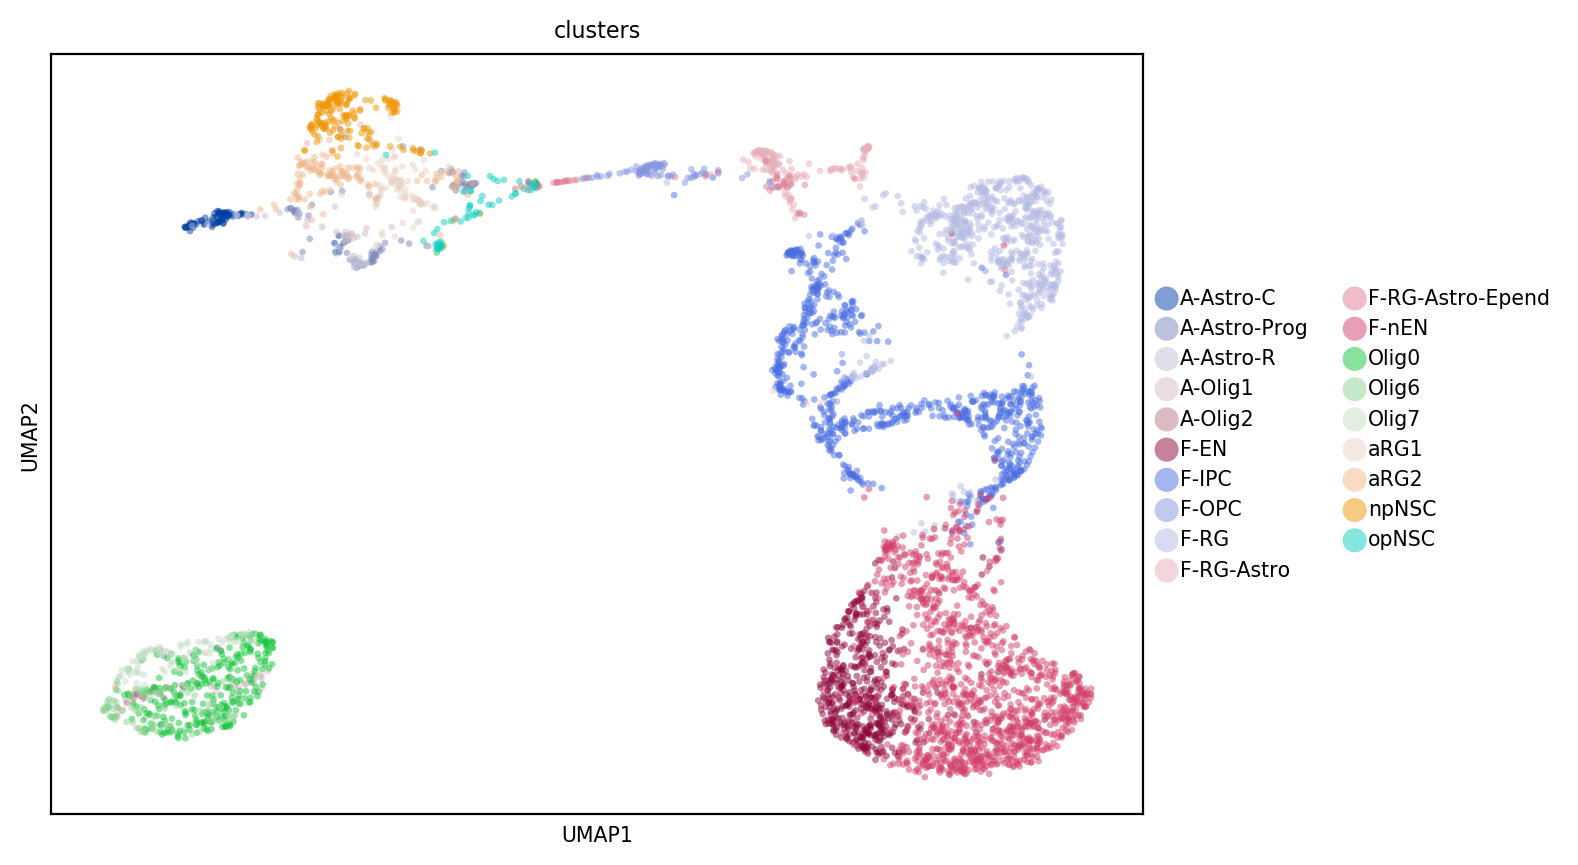

In [5]:
scv.pl.scatter(adata, color=['clusters'], alpha=.5,legend_loc='right margin',frameon=True)#


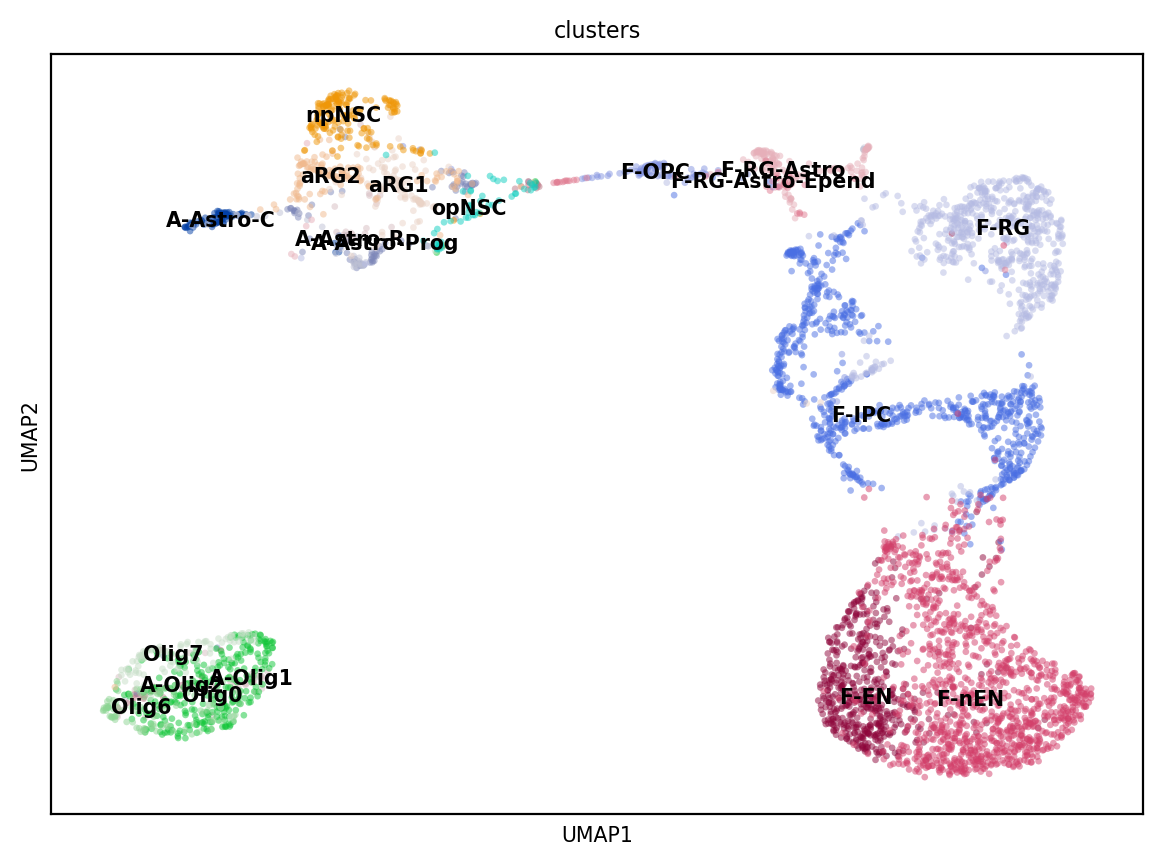

In [6]:
scv.pl.scatter(adata, alpha=.5,frameon=True,legend_loc='on data')

## Step1
Basic preprocessing: filtering genes and normalizing data

In [7]:
scv.pp.filter_and_normalize(adata, min_counts=min_counts, min_counts_u=min_counts, n_top_genes=n_top_genes)
print("Parameters: "+str(min_counts)+str(min_counts)+str(n_top_genes))

Parameters: 20203000


### Step 2
Compute the first- and second-order moments (needed for velocity estimation)

In [8]:

scv.pp.moments(adata, n_pcs=moments_n_pcs, n_neighbors=moments_neighbors)


### Step 3
Estimation of velocities

In [9]:
scv.tl.velocity(adata)


### Step4
Calculating probabilities of one cell transitioning into another cell, using cosine correlation  and are stored in 'velocity graph':

In [10]:
scv.tl.velocity_graph(adata,random_neighbors_at_max=1000000)

<Figure size 700x500 with 0 Axes>

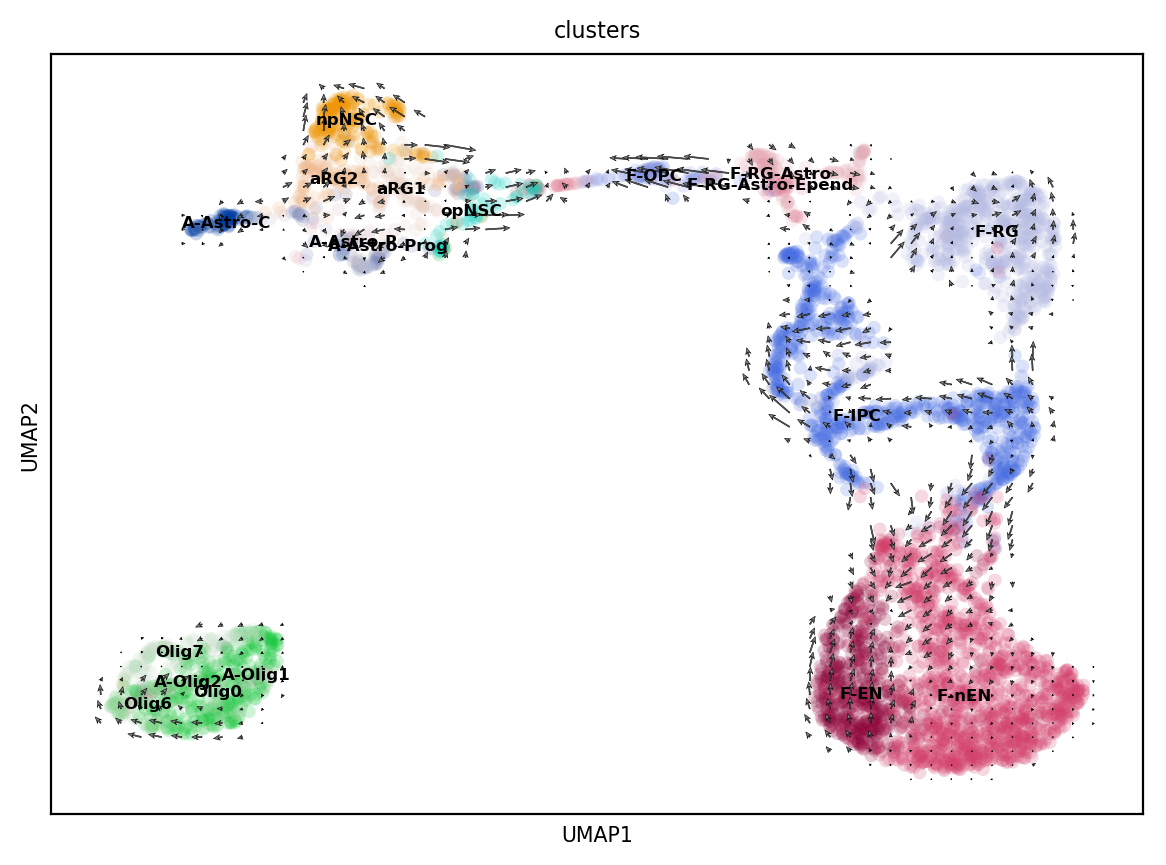

In [11]:
scv.pl.velocity_embedding_grid(adata,basis='umap',scale=1,arrow_size=1,legend_fontsize=6,legend_loc='on data',color="clusters",arrow_length=1,density=1,frameon=True)

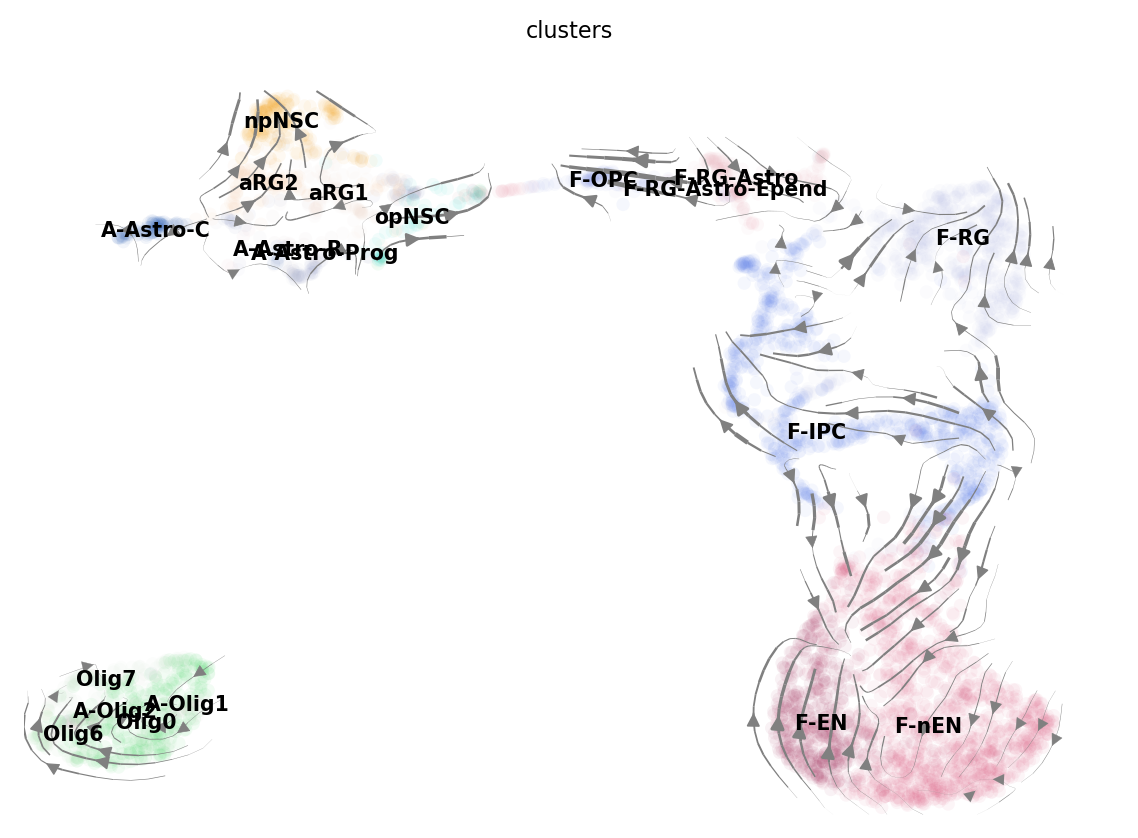

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap',legend_loc='on data', show=True,alpha=.05,color='clusters')#

### Step 5
PAGA graph abstraction (Wolf et al 2019) provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. In scvelo, PAGA is extended by velocity-inferred directionality.

In [13]:
scv.tl.paga(adata, groups='clusters',use_rna_velocity=False)
scv.tl.paga(adata, groups='clusters',use_rna_velocity=True)



In new versions simply use the following to get and visualize the transition confidence information.
```python
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')```

In [14]:
print(adata.uns["paga"]["transitions_confidence"][:2,:3])

  (0, 1)	0.05543778366476768
  (0, 2)	0.08811028508106047


Use diffrent transitions_confidence threshold for visualizations:


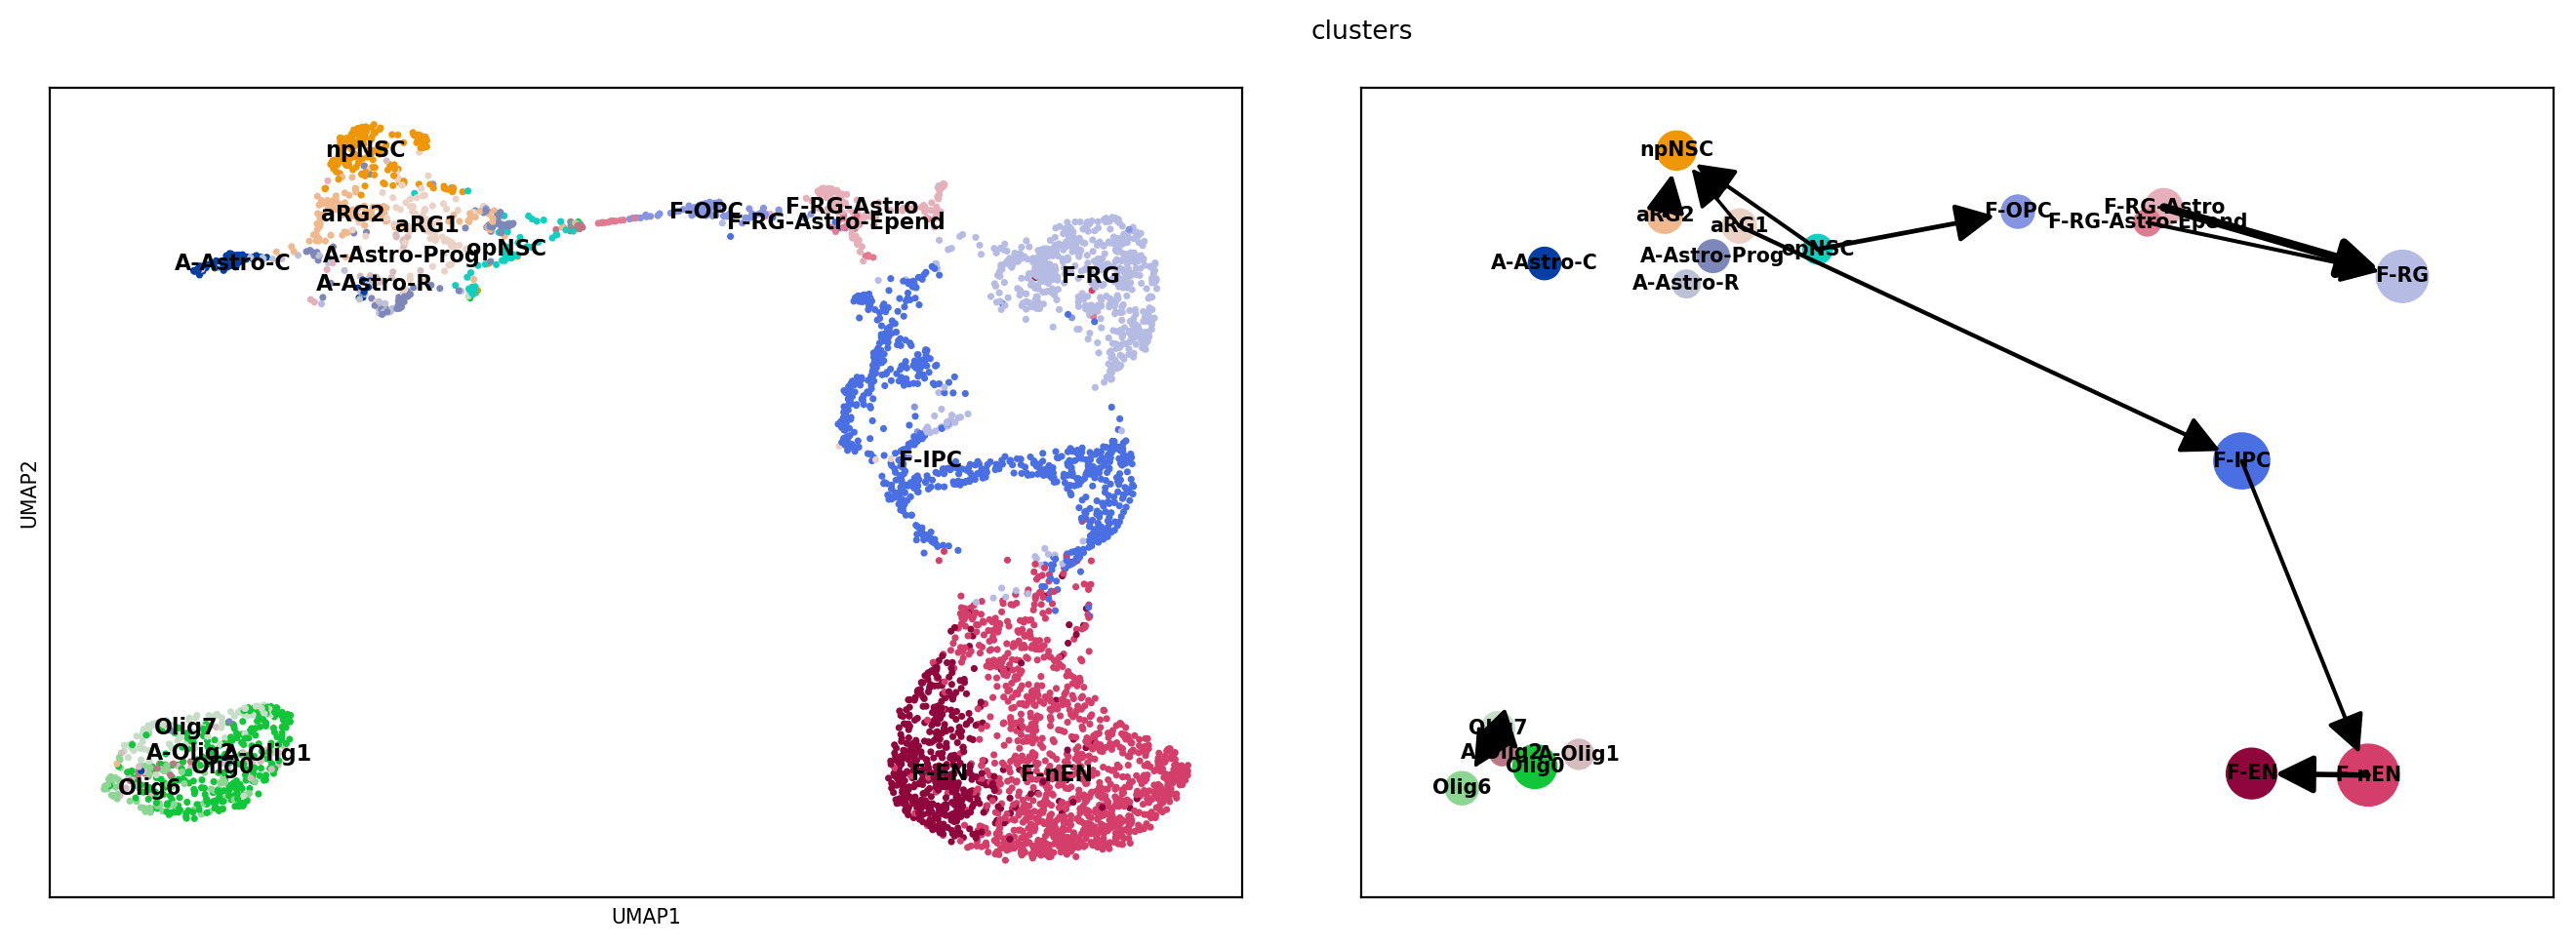

In [15]:
scv.pl.paga_compare(adata, basis='umap', threshold=0.3, arrowsize=30, edge_width_scale=.5,
transitions='transitions_confidence', frameon=True)

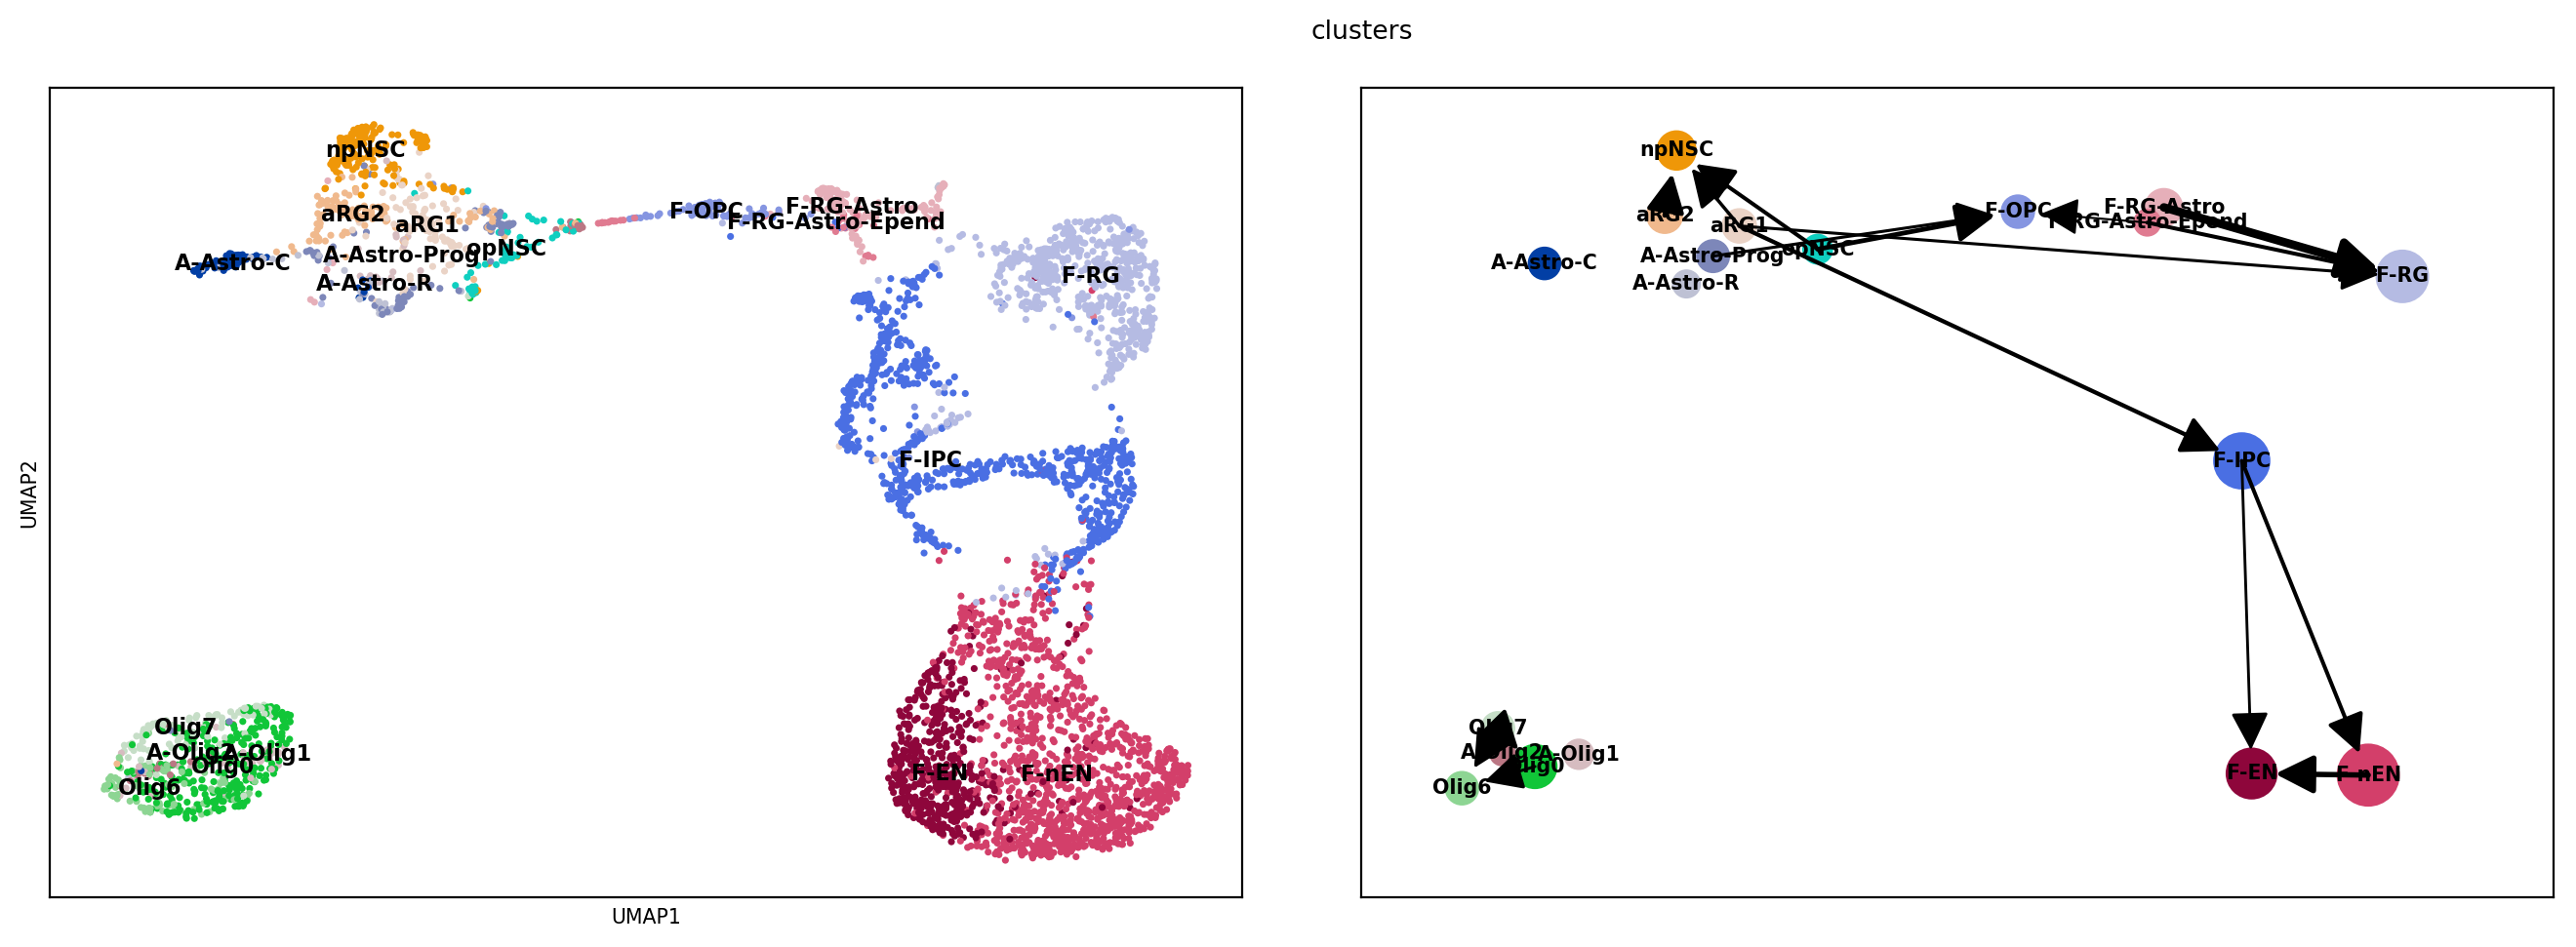

In [16]:
scv.pl.paga_compare(adata, basis='umap', threshold=0.2, arrowsize=30, edge_width_scale=.5,
transitions='transitions_confidence', frameon=True)

- As expected, progenitor cell of neurons (IPC) can give rise to new born Exciteroty Neurons (nEN) and nEN can give rise to EN.
- All SVZ NSC cells can give rise to npNSC, suggesting that npNSC cells are the most differenciated NSC cells, in this dataset.

### Supplementary analyses

In [17]:
scv.tl.cell_fate(adata, n_neighbors=n_neighbors_fate,copy=False)

In [18]:
scv.tl.terminal_states(adata,copy=False,self_transitions=True)#,self_transitions=True)# default : self_transitions=False,


/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  Runtim

<Figure size 700x500 with 0 Axes>

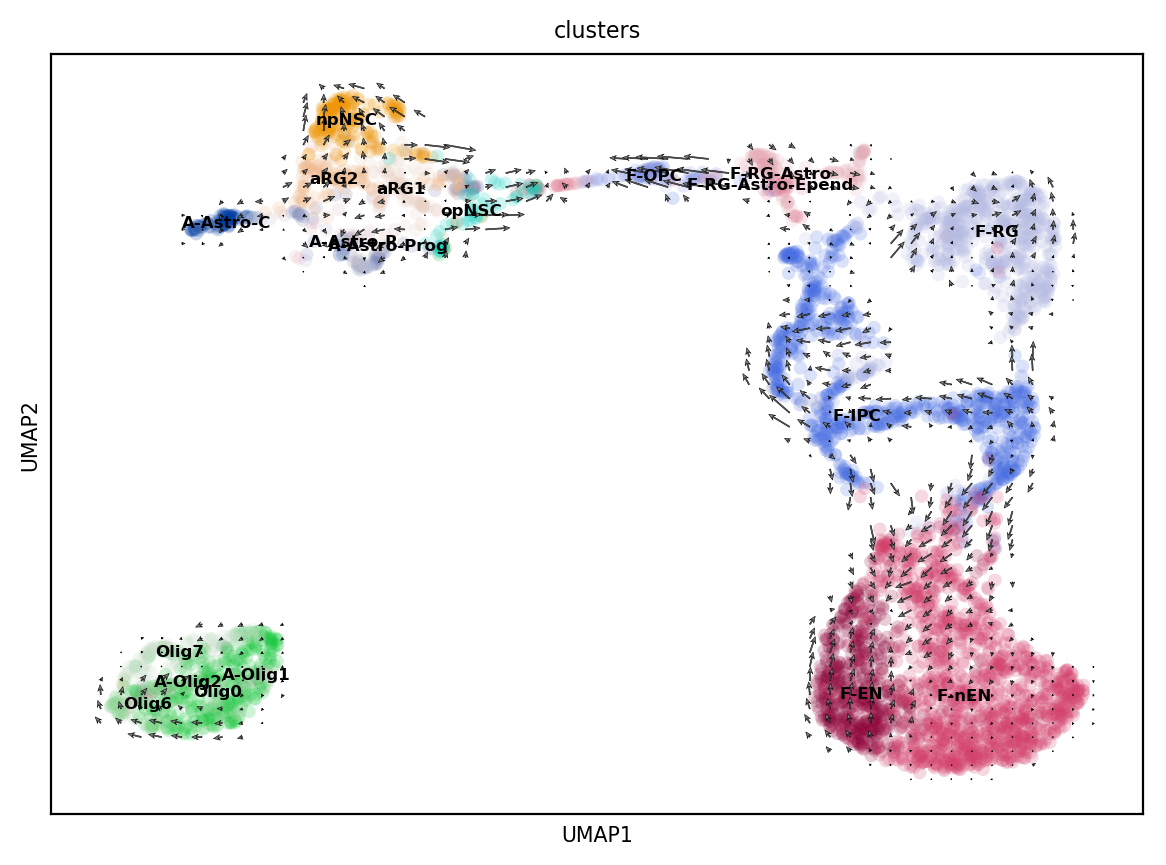

<Figure size 700x500 with 0 Axes>

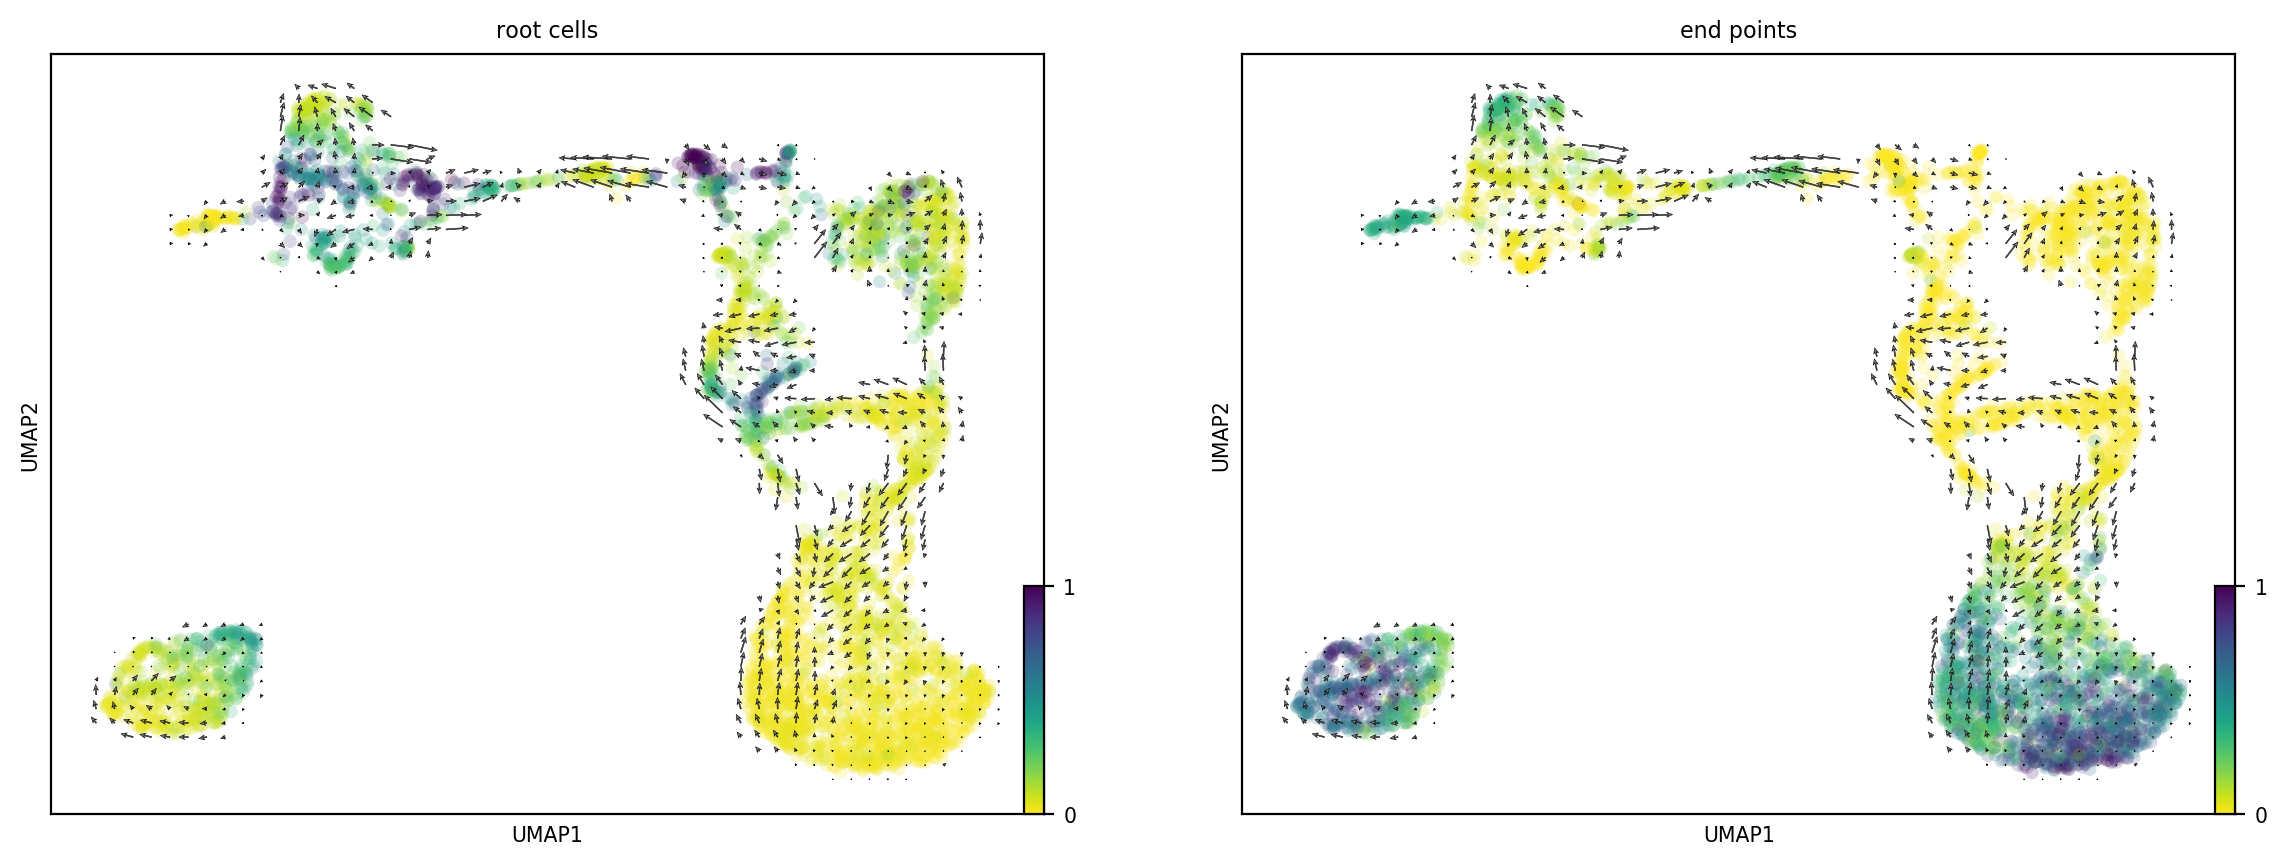

In [19]:
scv.pl.velocity_embedding_grid(adata,basis='umap',scale=1,arrow_size=1,legend_fontsize=6,legend_loc='on data',color="clusters",arrow_length=1,density=1,frameon=True)
scv.pl.velocity_embedding_grid(adata, color=[ 'root_cells', 'end_points'], legend_loc='on data',frameon=True)


- As expected, end points are in the most differentiated cells: Oligodendrocytes (e.g. Olig6) and Neurons (EN)
- In NSC clusters, roots are in aRG cells, and transitions are towards npNSC cells